In [1]:
import random
import os

import pickle 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# For dynamic bucketing
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset,Sampler
from torch.utils.data import DataLoader

import torchaudio
from torchaudio.transforms import Spectrogram

from IPython.display import Audio, Markdown, display

In [2]:
# Check if GPU availability and set the device
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

# Check if the device is set correctly
print(f"Device set to: {device}")

# Set the audio backend to soundfile (Uncomment if needed)
torchaudio.set_audio_backend("soundfile")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


/tmp/ipykernel_641238/690487593.py:13: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [3]:
class SpeechDataset(Dataset):
    def __init__(self, dataset_dir, set_type, rate, n_fft, hop_length, num_buckets=5):
        self.rate = rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.cache_file = os.path.join("cache/dynamic/", f"{set_type}_buckets.pkl")

        clean_dir = os.path.join(dataset_dir, f"clean_{set_type}_wav")
        noisy_dir = os.path.join(dataset_dir, f"noisy_{set_type}_wav")

        self.clean_files = sorted([os.path.join(clean_dir, f) for f in os.listdir(clean_dir)], key=lambda x: os.path.basename(x))
        self.noisy_files = sorted([os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)], key=lambda x: os.path.basename(x))

        self.spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=None)

        # Load or compute bucket assignments
        self.bucket_sizes, self.bucket_indices = self.bucket_handler(num_buckets)

    def compute_bucket_sizes(self, num_buckets):
        """
        Analyze dataset lengths and dynamically compute optimal bucket sizes.
        Uses k-means clustering to find natural groupings in sequence lengths.
        """
        print("Analyzing dataset for optimal bucket sizes...")
        lengths = []
        for file in self.clean_files:
            waveform, _ = torchaudio.load(file)
            lengths.append(waveform.shape[1])

        lengths = np.array(lengths).reshape(-1, 1)  # Reshape for clustering

        # Apply K-Means clustering to determine bucket centers
        kmeans = KMeans(n_clusters=num_buckets, random_state=42, n_init=10)
        kmeans.fit(lengths)
        bucket_sizes = np.sort(kmeans.cluster_centers_.flatten()).astype(int)
        print(f"Dynamic bucket sizes: {bucket_sizes}")

        return bucket_sizes

    def bucket_handler(self, num_buckets):
        """
        Assign each file to a dynamically computed bucket based on waveform length.
        """
        if os.path.exists(self.cache_file):
            print(f"Loading cached bucket assignments from {self.cache_file}...")
            with open(self.cache_file, "rb") as f:
                return pickle.load(f)

        bucket_sizes = self.compute_bucket_sizes(num_buckets)
        bucket_indices = []

        print(f"Assigning files to {len(bucket_sizes)} buckets...")
        for file in self.clean_files:
            waveform, _ = torchaudio.load(file)
            length = waveform.shape[1]
            bucket_idx = np.argmin(np.abs(bucket_sizes - length))  # Assign to closest bucket
            bucket_indices.append(bucket_idx)

        # Save to cache
        with open(self.cache_file, "wb") as f:
            pickle.dump((bucket_sizes, bucket_indices), f)

        return bucket_sizes, bucket_indices

    def collate(self, waveform, target_length):
        """Pad or truncate waveform to match target length."""
        if waveform.shape[1] < target_length:
            pad_length = target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_length))
        else:
            waveform = waveform[:, :target_length]
        return waveform

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        # Load noisy & clean audio
        noisy_waveform, n_sr = torchaudio.load(self.noisy_files[idx])
        clean_waveform, c_sr = torchaudio.load(self.clean_files[idx])

        # Convert stereo to mono
        noisy_waveform = noisy_waveform.mean(dim=0, keepdim=True) if noisy_waveform.shape[0] > 1 else noisy_waveform
        clean_waveform = clean_waveform.mean(dim=0, keepdim=True) if clean_waveform.shape[0] > 1 else clean_waveform

        # Resample if needed
        if n_sr != self.rate:
            noisy_waveform = T.Resample(n_sr, self.rate)(noisy_waveform)
        if c_sr != self.rate:
            clean_waveform = T.Resample(c_sr, self.rate)(clean_waveform)

        # Get bucket size and pad/truncate
        bucket_idx = self.bucket_indices[idx]
        target_length = self.bucket_sizes[bucket_idx]
        noisy_waveform = self.collate(noisy_waveform, target_length)
        clean_waveform = self.collate(clean_waveform, target_length)

        # Compute STFT (Complex Spectrogram)
        noisy_spec = self.spectrogram(noisy_waveform)
        clean_spec = self.spectrogram(clean_waveform)

        # Normalize spectrograms
        noisy_spec = (noisy_spec - noisy_spec.mean()) / (noisy_spec.std() + 1e-6)
        clean_spec = (clean_spec - clean_spec.mean()) / (clean_spec.std() + 1e-6)

        # Separate into real & imaginary components
        return noisy_spec.real, noisy_spec.imag, clean_spec.real, clean_spec.imag

In [4]:
class BucketSampler(Sampler):
    """Sampler that ensures batches contain samples of similar lengths."""
    def __init__(self, bucket_indices, batch_size):
        self.bucket_indices = bucket_indices
        self.batch_size = batch_size
        self.buckets = {}

        # Group indices by bucket
        for idx, bucket in enumerate(bucket_indices):
            if bucket not in self.buckets:
                self.buckets[bucket] = []
            self.buckets[bucket].append(idx)

        self.bucket_batches = []
        for bucket, indices in self.buckets.items():
            random.shuffle(indices)  # Shuffle within bucket
            self.bucket_batches.extend([indices[i:i+batch_size] for i in range(0, len(indices), batch_size)])

        # Shuffle the bucketed batches
        random.shuffle(self.bucket_batches)

    def __iter__(self):
        for batch in self.bucket_batches:
            yield batch

    def __len__(self):
        return len(self.bucket_batches)

In [5]:
# === Usage ===
dataset_dir = "../ED-Noisy-Speech-Datashare"
sr = 48000
n_fft = 1024
hop_length = 256

# Use dynamic bucketing
num_buckets = 5

# Initialize datasets
train_dataset = SpeechDataset(dataset_dir, "trainset_56spk", sr, n_fft, hop_length, num_buckets)
val_dataset = SpeechDataset(dataset_dir, "trainset_28spk", sr, n_fft, hop_length, num_buckets)
test_dataset = SpeechDataset(dataset_dir, "testset", sr, n_fft, hop_length, num_buckets)

# Initialize samplers
train_sampler = BucketSampler(train_dataset.bucket_indices, batch_size=4)
val_sampler = BucketSampler(val_dataset.bucket_indices, batch_size=4)
test_sampler = BucketSampler(test_dataset.bucket_indices, batch_size=4)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_sampler=val_sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler, num_workers=4)


Loading cached bucket assignments from cache/dynamic/trainset_56spk_buckets.pkl...
Loading cached bucket assignments from cache/dynamic/trainset_28spk_buckets.pkl...
Loading cached bucket assignments from cache/dynamic/testset_buckets.pkl...


In [6]:
def visualize_buckets(dataset, title_prefix="Train"):
    # Extract original waveform lengths
    original_lengths = [torchaudio.load(f)[0].shape[1] for f in dataset.clean_files]

    # Extract bucketed distribution
    bucket_sizes = dataset.bucket_sizes  
    bucket_counts = [dataset.bucket_indices.count(i) for i in range(len(bucket_sizes))]  

    # Get sampling rate
    sr = dataset.rate  

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Plot Histogram of Original Lengths
    axes[0].hist(original_lengths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_xlabel("Waveform Length (samples)")
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"{title_prefix} Dataset: Original Waveform Length Distribution")
    axes[0].grid(True)

    # Plot Bar Chart of Buckets
    axes[1].bar(bucket_sizes, bucket_counts, width=sr//2, color='orange', edgecolor='black', alpha=0.7)
    axes[1].set_xlabel("Bucket Size (samples)")
    axes[1].set_ylabel("Number of Samples")
    axes[1].set_title(f"{title_prefix} Dataset: Bucketed Distribution")
    axes[1].set_xticks(bucket_sizes)
    axes[1].set_xticklabels([f"{b//sr}s" for b in bucket_sizes])  # Convert to seconds
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

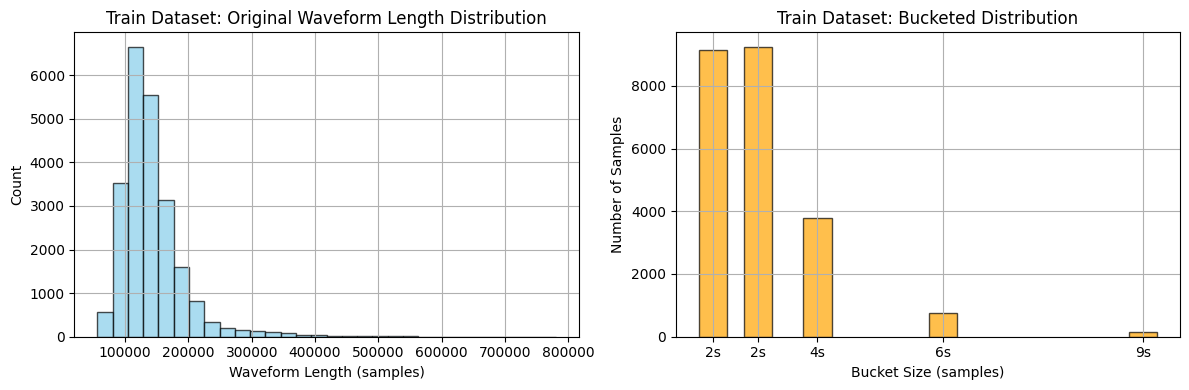

In [7]:
# Visualize bucket distributions
visualize_buckets(train_dataset)

In [8]:
def train_eval(device, model, train_loader, val_loader, epochs, lr, save_pth):
    # Move model to device
    model.to(device)
    # Optimizer & Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Training and Validation variables
    best_val_loss = float('inf')  
    train_losses, val_losses = [], []  
    val_snrs = []

    # Iterate over epochs
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        # Training Loop
        for tn_real, tn_imag, tc_real, tc_imag in train_loader:
            noisy_real, noisy_imag = tn_real.to(device), tn_imag.to(device)
            clean_real, clean_imag = tc_real.to(device), tc_imag.to(device)

            optimizer.zero_grad()
            outputs_real, outputs_imag = model(noisy_real, noisy_imag)
            loss = criterion(outputs_real, clean_real) + criterion(outputs_imag, clean_imag)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation Loop
        model.eval()
        total_val_loss = 0.0
        snr_sum, snr_count = 0.0, 0 
        
        with torch.no_grad():
            for vn_real, vn_imag, vc_real, vc_imag in val_loader:
                val_real, val_imag = vn_real.to(device), vn_imag.to(device)
                val_clean_real, val_clean_imag = vc_real.to(device), vc_imag.to(device)

                val_outputs_real, val_outputs_imag = model(val_real, val_imag)
                val_loss = criterion(val_outputs_real, val_clean_real) + criterion(val_outputs_imag, val_clean_imag)
                total_val_loss += val_loss.item()

                # Compute Signal-to-Noise Ratio (SNR) as accuracy
                snr_real = (val_clean_real.norm() / (val_outputs_real - val_clean_real).norm()).item()
                snr_imag = (val_clean_imag.norm() / (val_outputs_imag - val_clean_imag).norm()).item()
                avg_snr = (snr_real + snr_imag) / 2
                snr_sum += avg_snr
                snr_count += 1

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_snr = snr_sum / snr_count 
        val_losses.append(avg_val_loss)
        val_snrs.append(avg_val_snr)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val SNR: {avg_val_snr:.2f} dB")

        # Save the best model based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_pth)
            print(f"✔ Model saved to {save_pth} (Best Val Loss: {best_val_loss:.4f})")

    print("Training complete!")

    # Plot Loss & Accuracy Trends
    plt.figure(figsize=(12, 5))

    # Training & Validation Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, marker='o', color='b', label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, marker='s', color='r', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.grid(True)
    plt.legend()

    # Validation SNR Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), val_snrs, marker='^', color='g', label="Val SNR (dB)")
    plt.xlabel("Epochs")
    plt.ylabel("SNR (dB)")
    plt.title("Validation SNR Over Epochs")
    plt.grid(True)
    plt.legend()

    plt.show()

In [9]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
        )

        # Bottleneck with Residual Connection
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(),
        )

        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.PReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        )

        # Dropout Layer to reduce overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self, real, imag):
        orig_size = real.shape[2:]

        # Stack real and imaginary as two-channel input
        x = torch.cat((real, imag), dim=1)

        # Pass through CNN
        x = self.encoder(x)
        
        # Residual Connection in Bottleneck
        residual = x
        x = self.bottleneck(x) + residual  # Adding residual

        # Dropout before decoding
        x = self.dropout(x)

        x = self.decoder(x)

        # Ensure output size matches the original input
        x = F.interpolate(x, size=orig_size, mode="bilinear", align_corners=False)

        # Split the output back into real and imaginary components
        out_real, out_imag = torch.chunk(x, 2, dim=1)

        return out_real, out_imag

Epoch [1/10] - Loss: 0.3815, Val Loss: 0.3984, Val SNR: 1.72 dB
✔ Model saved to Models/modifiedv1.pth (Best Val Loss: 0.3984)


Epoch [2/10] - Loss: 0.3138, Val Loss: 0.4665, Val SNR: 1.72 dB


Epoch [3/10] - Loss: 0.2911, Val Loss: 0.5009, Val SNR: 1.73 dB


Epoch [4/10] - Loss: 0.2804, Val Loss: 0.5433, Val SNR: 1.73 dB


Epoch [5/10] - Loss: 0.2732, Val Loss: 0.5227, Val SNR: 1.75 dB


Epoch [6/10] - Loss: 0.2675, Val Loss: 0.5712, Val SNR: 1.74 dB


Epoch [7/10] - Loss: 0.2633, Val Loss: 0.5608, Val SNR: 1.75 dB


Epoch [8/10] - Loss: 0.2595, Val Loss: 0.5240, Val SNR: 1.76 dB


Epoch [9/10] - Loss: 0.2563, Val Loss: 0.5223, Val SNR: 1.77 dB


Epoch [10/10] - Loss: 0.2533, Val Loss: 0.4938, Val SNR: 1.78 dB
Training complete!


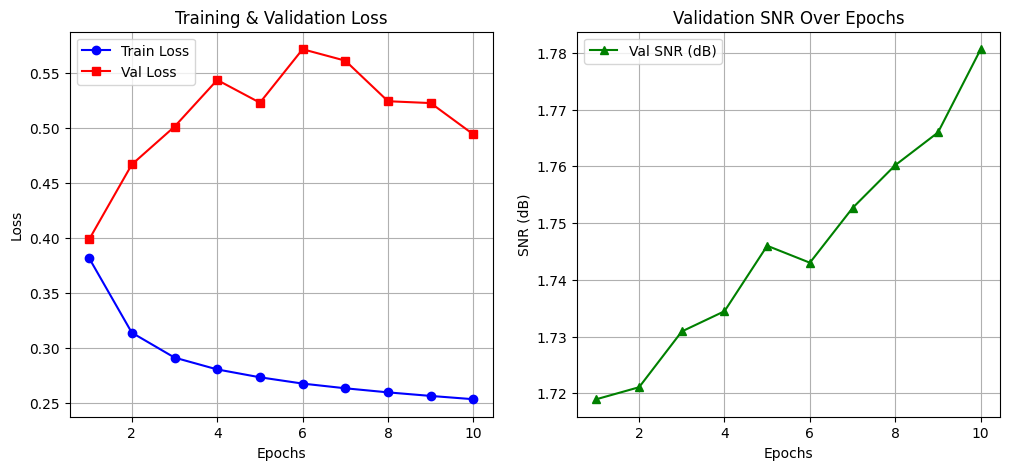

In [ ]:
# Set the train and eval parameters
epochs = 10
lr = 1e-3
model_pth = "Models/ModelA.pth"

# Initialize the model
model = DenoisingCNN()

# Train the model
train_eval(device, model, train_loader, val_loader, epochs, lr, model_pth)

In [11]:
def denoise(device, model, model_pth, noisy_pth, output_pth, sr, nfft, hop_length):

    # Ensure the model file exists
    if not os.path.exists(model_pth):
        raise FileNotFoundError(f"Model file not found: {model_pth}")
    
    if not os.path.exists(noisy_pth):
        raise FileNotFoundError(f"Noisy audio file not found: {noisy_pth}")

    # Load model weights
    model.load_state_dict(torch.load(model_pth, map_location=device))
    model.to(device)
    model.eval()

    # Define spectrogram transforms
    spectrogram = T.Spectrogram(n_fft=nfft, hop_length=hop_length, power=None).to(device)
    inverse_spectrogram = T.InverseSpectrogram(n_fft=nfft, hop_length=hop_length).to(device)

    # Load noisy audio
    noisy_signal, orig_sr = torchaudio.load(noisy_pth)

    # Convert stereo to mono
    if noisy_signal.shape[0] > 1:
        noisy_signal = noisy_signal.mean(dim=0, keepdim=True)

    # Resample if necessary
    if orig_sr != sr:
        noisy_signal = T.Resample(orig_sr, sr)(noisy_signal)

    # Compute spectrogram (Complex-valued)
    noisy_spec = spectrogram(noisy_signal.to(device))

    # Normalize the spectrogram
    noisy_spec = (noisy_spec - noisy_spec.mean()) / (noisy_spec.std() + 1e-6)

    # Separate real and imaginary components
    noisy_real, noisy_imag = noisy_spec.real, noisy_spec.imag

    # Process through model
    with torch.no_grad():
        denoised_real, denoised_imag = model(noisy_real.unsqueeze(1), noisy_imag.unsqueeze(1))  # Add channel dim

    # Remove extra channel dim
    denoised_real, denoised_imag = denoised_real.squeeze(1), denoised_imag.squeeze(1)

    # Reconstruct complex spectrogram
    denoised_spec = torch.complex(denoised_real, denoised_imag)

    # Convert back to waveform
    denoised_waveform = inverse_spectrogram(denoised_spec)

    # Prevent potential clipping issues
    denoised_waveform = torch.clamp(denoised_waveform, min=-1.0, max=1.0)

    # Save the denoised output
    torchaudio.save(output_pth, denoised_waveform.cpu(), sr)
    print(f"✅ Denoised audio saved to: {output_pth}") 

In [12]:
def display_audio(noisy_pth, clean_pth, denoised_pth, sr):
    # Load audio files
    noisy_waveform, _ = torchaudio.load(noisy_pth)
    clean_waveform, _ = torchaudio.load(clean_pth)
    denoised_waveform, _ = torchaudio.load(denoised_pth)

    # Display audio comparisons
    display(Markdown("## 🎧 Audio Comparisons"))
    
    display(Markdown("### 🔊 Noisy Audio"))
    display(Audio(noisy_waveform.cpu().numpy(), rate=sr))
    
    display(Markdown("### 🎵 Clean Audio"))
    display(Audio(clean_waveform.cpu().numpy(), rate=sr))
    
    display(Markdown("### 🚀 Denoised Audio"))
    display(Audio(denoised_waveform.cpu().numpy(), rate=sr))


In [ ]:
# Set the paths
noisy_pth = "../ED-Noisy-Speech-Datashare/noisy_testset_wav/p232_014.wav"
output_pth = "Output/ModelA.wav"
clean_pth = "../ED-Noisy-Speech-Datashare/clean_testset_wav/p232_014.wav"

# Perform the denoising
denoise(device, model, model_pth, noisy_pth, output_pth, sr, n_fft, hop_length)

✅ Denoised audio saved to: Output/modelv1.wav


In [14]:
# Display the audio
display_audio(noisy_pth, clean_pth, output_pth, sr)

## 🎧 Audio Comparisons

### 🔊 Noisy Audio

### 🎵 Clean Audio

### 🚀 Denoised Audio